In [ ]:
# This R environment comes with many helpful analytics packages installed
# It is defined by the kaggle/rstats Docker image: https://github.com/kaggle/docker-rstats
# For example, here's a helpful package to load

library(tidyverse) # metapackage of all tidyverse packages

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

list.files(path = "../input")

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# Tutorial de modelos VAR 

En este tutorial aplicaremos los conceptos más relevantes de los modelos vectoriales autoregresivos (VAR) en tres series de tiempo del índice PIB de Reino Unido (UK), Canadá (Canada) y Estados Unidos (USA). Utilizaremos la librería VAR y en segunda instancia la librería MTS.

Comenzaremos con la importación de los datos y la visualización de los mismos. Posteriormente, aplicaremos las pruebas de cointegración a manera de saber si el sistema posee dicha propiedad de cointegración y si con ello, debemos diferenciar u optar por otro modelo. Ya preparados los datos, aplicaremos inicialmente la librería vars, que es una librería muy usual y cuyos resultados de las ecuaciones de regresión se obtienen directamente, a diferencia de la librería MTS. Como comentamos, hay diferencias ventajas y desventajas en el uso de cada uno de estas. Por ejemplo, la librería MTS permite la obtención de modelos depurados. 

De manera general, veremos que para aplicar los modelos VAR, debemos inicialmente identificar el nivel regresivo del sistema, aplicar el modelo de regresión y posteriormente, en el caso de que nuestro interés recaiga en un pronóstico, deberemos aplicar la función de recuperación de nivel de los resultados.
Por otro lado, aplicaremos para el caso particular de la función vars, la función impulso-respuesta a uno de los modelos obtenidos. Te recomiendo revisar cada uno de los resultados e intrepretaciones de cada librería, ya que dichos resultados se ofrecen de manera aparentemente diferente, pero conducen a los mismos resultados. 

**Contenido**
1. [Importación de librerías y de datos](#1)
1. [Identificación nivel regresivo y prueba de cointegración.](#2)
1. [Diferenciación de las series](#3)
1. [Modelación con librería vars](#4)
    1. [Selección orden regresivo](#7)
    1. [Regresión VAR](#8)
1. [Modelación con librería MTS](#9)
    1. [Selección orden regresivo](#9a)
    1. [Regresión VAR](#9b)
    1. [Simplificación del modelo](#11)
    1. [Revisión del modelo](#12)
1. [Análisis Impulso - Respuesta](#13)
1. [Predicción](#15)
1. [Recuperación del nivel en el pronóstico](#16)


<a id="1"></a> <br>
## 1. Importación de librerías y de datos
Comenzaremos con la importación de librerías y datos.

In [5]:
#Incluimos las librerías de modelamiento y manejo de datos.
install.packages('MTS')
install.packages("devtools")
library(devtools)
library(fpp3)
library(urca)
library(vars)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



In [6]:
install.packages("MTS_VERSION.tar.gz",repos=NULL,type="source")
library(MTS)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Warning message in install.packages("MTS_VERSION.tar.gz", repos = NULL, type = "source"):
“installation of package ‘MTS_VERSION.tar.gz’ had non-zero exit status”


Procedemos a importar los datos. Estos datos poseen una estructura de texto. Por lo que posteriormente, les daremos un formato de serie de tiempo.

In [23]:
da=read.table("../input/var-gdp-ex/q-gdp-ukcaus.txt",header=T)
head(da)
#/kaggle/input/var-gdp-ex/q-gdp-ukcaus.txt

,year,mon,uk,ca,us
,<int>,<int>,<int>,<int>,<int>
1,1980,1,172436,624794,5908500
2,1980,4,169359,623433,5787400
3,1980,7,169038,623215,5776600
4,1980,10,167180,630215,5883500
5,1981,1,166052,645957,6005700
6,1981,4,166393,651954,5957800


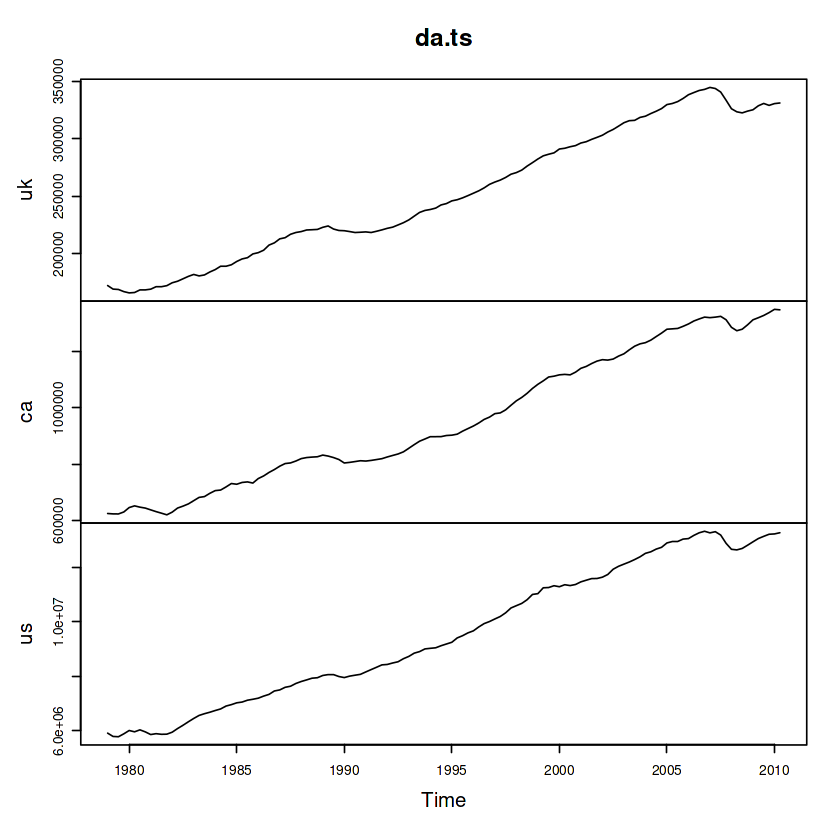

In [28]:
# Debemos visualizar los datos, para ello, pasamos los datos a formato ts(), a las columnas de datos del índice.
da.ts=ts(da[3:5], start=c(1980-01), frequency=4)
plot(da.ts)

In [33]:
#Ya que las tendencias poseen un comportamiento exponencial en alguna de sus secciones, procedemos a aplicar la función log()
#gdp=log(da[,3:5])
gdp=log(da.ts)

<a id="2"></a> <br>
## 2. Identificación nivel regresivo y prueba de cointegración

In [34]:
#Identificamos el nivel regresivo, mediante la función VARselect
nivelka=VARselect(da.ts, lag.max = 7, type = "const")
nivelka$selection

AIC(n)  HQ(n)  SC(n) FPE(n) 
     3      2      2      3

Ya que los resultados de la prueba de criterio de información muestran que el orden regresivo puede ser 2 o 3, podemos elegir el modelo con un orden de 2. Este orden es el que se le indica a la función de cointegración, que se muestra a continuación, así como el modelo de VAR.

In [35]:
# Aplicamos la prueba de Johansen para la identificación de relaciones lineales entre las series, lo que nos indica la condición de cointegración.
johatest=ca.jo(da.ts, type = "trace", K=2, ecdet ="none", spec = "longrun") #
summary(johatest)


###################### 
# Johansen-Procedure # 
###################### 

Test type: trace statistic , with linear trend 

Eigenvalues (lambda):
[1] 0.05641714 0.02330768 0.01380949

Values of teststatistic and critical values of test:

          test 10pct  5pct  1pct
r <= 2 |  1.72  6.50  8.18 11.65
r <= 1 |  4.65 15.66 17.95 23.52
r = 0  | 11.85 28.71 31.52 37.22

Eigenvectors, normalised to first column:
(These are the cointegration relations)

             uk.l2      ca.l2        us.l2
uk.l2  1.000000000  1.0000000  1.000000000
ca.l2  0.009333755  1.3923580 -0.310944009
us.l2 -0.023296237 -0.1781008  0.005577652

Weights W:
(This is the loading matrix)

           uk.l2         ca.l2       us.l2
uk.d -0.08218129  0.0004984907 0.000782678
ca.d -0.09329137 -0.0093872929 0.050768677
us.d -1.12229841  0.0123490456 1.144745216


Como podemos observar a partir de los resultados de la prueba de cointegración, las series no están cointegradas. Debemos así revisar si las series son estacionarias, para poder proceder con la diferenciación y modelo VAR.

<a id="3"></a> <br>
## 3. Diferenciación de las series

In [38]:
# Importamos la librería de tserires para la aplicación de la prueba de Dickey Fuller.
library(tseries)
adf.test(da[,3])
adf.test(da[,4])
adf.test(da[,5])


	Augmented Dickey-Fuller Test

data:  da[, 3]
Dickey-Fuller = -1.7969, Lag order = 4, p-value = 0.6609
alternative hypothesis: stationary



	Augmented Dickey-Fuller Test

data:  da[, 4]
Dickey-Fuller = -2.4511, Lag order = 4, p-value = 0.3891
alternative hypothesis: stationary



	Augmented Dickey-Fuller Test

data:  da[, 5]
Dickey-Fuller = -2.5011, Lag order = 4, p-value = 0.3683
alternative hypothesis: stationary


Como podemos observar de los resultados de la prueba Dickey_Fuller, las series no son estacionarias ya que el p-valor en cada uno de los resultados, muestran la presencia de una raíz unitaria. Con ello, debemos proceder a diferenciar las series.

In [43]:
#Una manera de diferenciar las series es partiendo de los datos en forma de texto, donde, podemos simplemente generar la diferencia al haber movilizado un dato y aplicado la diferencia.
z=gdp[2:126,]-gdp[1:125,]
head(z)
dim(gdp)

uk,ca,us
-0.018005431,-0.0021806940,-0.020708851
-0.001897181,-0.0003497379,-0.001867866
-0.011052465,0.0111694674,0.018336549
-0.006770084,0.0246719071,0.020557195
0.002051468,0.0092410692,-0.008007733
0.013479031,-0.0070853560,0.012078892


[1] 126   3

Otra manera de diferenciar este sistema es simplemente tomar cada serie estabilizada de la tendencia, aplicar la función diff() y posteriormente, unir las series.

In [52]:
uk=diff(gdp[,1],1)
ca=diff((gdp[,2]),1)
us=diff(gdp[,3],1)
z=cbind.data.frame(uk,ca,us)
head(z)
str(z)

,uk,ca,us
,<dbl>,<dbl>,<dbl>
1,-0.018005431,-0.0021806940,-0.020708851
2,-0.001897181,-0.0003497379,-0.001867866
3,-0.011052465,0.0111694674,0.018336549
4,-0.006770084,0.0246719071,0.020557195
5,0.002051468,0.0092410692,-0.008007733
6,0.013479031,-0.0070853560,0.012078892


'data.frame':	125 obs. of  3 variables:
 $ uk: Time-Series  from 1979 to 2010: -0.01801 -0.0019 -0.01105 -0.00677 0.00205 ...
 $ ca: Time-Series  from 1979 to 2010: -0.00218 -0.00035 0.01117 0.02467 0.00924 ...
 $ us: Time-Series  from 1979 to 2010: -0.02071 -0.00187 0.01834 0.02056 -0.00801 ...


<a id="4"></a> <br>
### 4. Modelación con librería vars

Tras haber identificado que el modelo VAR es un modelo adecuado para aplicar al sistema vectorial, procedemos nuevamente con la selección del orden regresivo.

<a id="7"></a> <br>
### A. Selección orden regresivo
Procedemos a identificar el nivel regresivo de las series.

In [57]:
# En la librería de VAR, la función que permite identificar el orden regresivo es la función de VARselect(). Se elige el máximo de rezagos de lag.max=7.
nivelk=VARselect(z, lag.max = 7, type = "const")
nivelk$selection

AIC(n)  HQ(n)  SC(n) FPE(n) 
     4      1      1      4

Los resultados muestran que tanto 1 como 4, en este caso, ya que el orden mínimo de p, es 2, elegimos ese valor.

<a id="8"></a> <br>
### B: Regresión VAR.

Apliquemos la función de vars() de la paquetería de VAR, para observar las diferencias en los resultados de ambas librerías.

In [58]:
#Podemos volver a llamar la librería de vars y aplicar el regresión habiendo encontrado que p=2.
library(vars)
m0=vars::VAR(z, p=2)
summary(m0)


VAR Estimation Results:
Endogenous variables: uk, ca, us 
Deterministic variables: const 
Sample size: 123 
Log Likelihood: 1408.82 
Roots of the characteristic polynomial:
0.6136 0.6136 0.356 0.3321 0.3321 0.03676
Call:
vars::VAR(y = z, p = 2)


Estimation results for equation uk: 
uk = uk.l1 + ca.l1 + us.l1 + uk.l2 + ca.l2 + us.l2 + const 

       Estimate Std. Error t value Pr(>|t|)    
uk.l1 0.3930669  0.0934184   4.208 5.11e-05 ***
ca.l1 0.1031057  0.0983843   1.048    0.297    
us.l1 0.0521366  0.0911264   0.572    0.568    
uk.l2 0.0566012  0.0923736   0.613    0.541    
ca.l2 0.1055224  0.0875590   1.205    0.231    
us.l2 0.0188946  0.0938209   0.201    0.841    
const 0.0012582  0.0007266   1.731    0.086 .  
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


Residual standard error: 0.005473 on 116 degrees of freedom
Multiple R-Squared: 0.3829,	Adjusted R-squared: 0.3509 
F-statistic: 11.99 on 6 and 116 DF,  p-value: 1.907e-10 


Estimation results for equ

Como podemos observar a partir de los resultados de regresión, tenemos tres ecuaciones de regresión que corresponden a cada uno de los países. Si nos fijamos en la regresión de UK, el PIB de este país dependería únicamente de su primer rezago. Sin embargo, si miramos los resultados para Canadá, el PIB de este, depende de todos los primeros rezagos de los demás países, además del segundo de UK a un nivel de significancia del 5%.

<a id="9"></a> <br>
### 5. Modelación con libreria MTS

Apliquemos el proceso pero ahora mediante la librería MTS. Comencemos con la identificación del orden regresivo.

<a id="9a"></a> <br>
### A. Selección del orden regresivo

Este es un primer paso en la modelación.

In [59]:
# En la librería de MTS, la función que permite la identificación del nivel regresivo es la de VARorder().
VARorder(z) 

selected order: aic =  2 
selected order: bic =  1 
selected order: hq =  1 
Summary table:  
       p      AIC      BIC       HQ     M(p) p-value
 [1,]  0 -30.9560 -30.9560 -30.9560   0.0000  0.0000
 [2,]  1 -31.8830 -31.6794 -31.8003 115.1329  0.0000
 [3,]  2 -31.9643 -31.5570 -31.7988  23.5389  0.0051
 [4,]  3 -31.9236 -31.3127 -31.6754  10.4864  0.3126
 [5,]  4 -31.8971 -31.0826 -31.5662  11.5767  0.2382
 [6,]  5 -31.7818 -30.7636 -31.3682   2.7406  0.9737
 [7,]  6 -31.7112 -30.4893 -31.2148   6.7822  0.6598
 [8,]  7 -31.6180 -30.1925 -31.0389   4.5469  0.8719
 [9,]  8 -31.7570 -30.1279 -31.0952  24.4833  0.0036
[10,]  9 -31.6897 -29.8569 -30.9451   6.4007  0.6992
[11,] 10 -31.5994 -29.5630 -30.7721   4.3226  0.8889
[12,] 11 -31.6036 -29.3636 -30.6936  11.4922  0.2435
[13,] 12 -31.6183 -29.1746 -30.6255  11.8168  0.2238
[14,] 13 -31.6718 -29.0245 -30.5964  14.1266  0.1179


Como podemos observar, el p-valor de la prueba de criterio de información señala que p=2, ya que el este valor se infla en el tercer rezago. Igualmente, esta selección podría ser en p=8. Elegimos p=2 por simplicidad del modelo.

<a id="9b"></a> <br>
### B. Regresión VAR

Generemos el modelo de regresión.

In [60]:
#Ahora, aplicamos la función de VAR, para generar el modelo de regresión:
m1=MTS::VAR(z,2)

Constant term: 
Estimates:  0.001258163 0.001231581 0.002895581 
Std.Error:  0.0007266338 0.0007382941 0.000816888 
AR coefficient matrix 
AR( 1 )-matrix 
      [,1]  [,2]   [,3]
[1,] 0.393 0.103 0.0521
[2,] 0.351 0.338 0.4691
[3,] 0.491 0.240 0.2356
standard error 
       [,1]   [,2]   [,3]
[1,] 0.0934 0.0984 0.0911
[2,] 0.0949 0.1000 0.0926
[3,] 0.1050 0.1106 0.1024
AR( 2 )-matrix 
        [,1]   [,2]     [,3]
[1,]  0.0566  0.106  0.01889
[2,] -0.1914 -0.175 -0.00868
[3,] -0.3120 -0.131  0.08531
standard error 
       [,1]   [,2]   [,3]
[1,] 0.0924 0.0876 0.0938
[2,] 0.0939 0.0890 0.0953
[3,] 0.1038 0.0984 0.1055
  
Residuals cov-mtx: 
             [,1]         [,2]         [,3]
[1,] 2.824442e-05 2.654091e-06 7.435286e-06
[2,] 2.654091e-06 2.915817e-05 1.394879e-05
[3,] 7.435286e-06 1.394879e-05 3.569657e-05
  
det(SSE) =  2.258974e-14 
AIC =  -31.13328 
BIC =  -30.726 
HQ  =  -30.96783 


Como podemos observar, estos resultados son iguales que los obtenidos por la librería de vars. Revisemos ahora, los residuales.

Ljung-Box Statistics:  
          m       Q(m)     df    p-value
 [1,]   1.000     0.816 -12.000     1.00
 [2,]   2.000     3.978  -3.000     1.00
 [3,]   3.000    16.665   6.000     1.00
 [4,]   4.000    35.122  15.000     0.00
 [5,]   5.000    38.189  24.000     0.03
 [6,]   6.000    41.239  33.000     0.15
 [7,]   7.000    47.621  42.000     0.25
 [8,]   8.000    61.677  51.000     0.15
 [9,]   9.000    67.366  60.000     0.24
[10,]  10.000    76.930  69.000     0.24
[11,]  11.000    81.567  78.000     0.37
[12,]  12.000    93.112  87.000     0.31
[13,]  13.000   105.327  96.000     0.24
[14,]  14.000   116.279 105.000     0.21
[15,]  15.000   128.974 114.000     0.16
[16,]  16.000   134.704 123.000     0.22
[17,]  17.000   138.552 132.000     0.33
[18,]  18.000   146.256 141.000     0.36
[19,]  19.000   162.418 150.000     0.23
[20,]  20.000   171.948 159.000     0.23
[21,]  21.000   174.913 168.000     0.34
[22,]  22.000   182.056 177.000     0.38
[23,]  23.000   190.276 186.000  

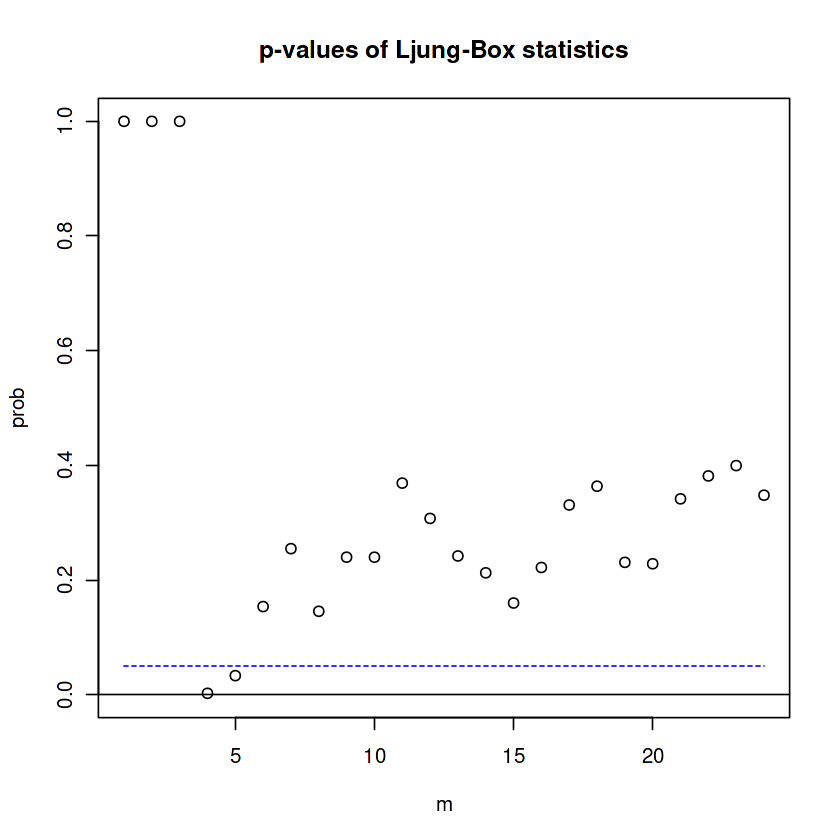

In [65]:
#Separemos primero los residuales del modelo de regresión y apliquemos la función de mq() para la revisión de la calidad del modelo.
#Indicamos los grados de libertad del modelo, que son 18 (2 matrices autorregresivas de 9 coeficientes, cada uno, mas 3 ordenadas).
resi=m1$residuals
mq(resi, adj=21)

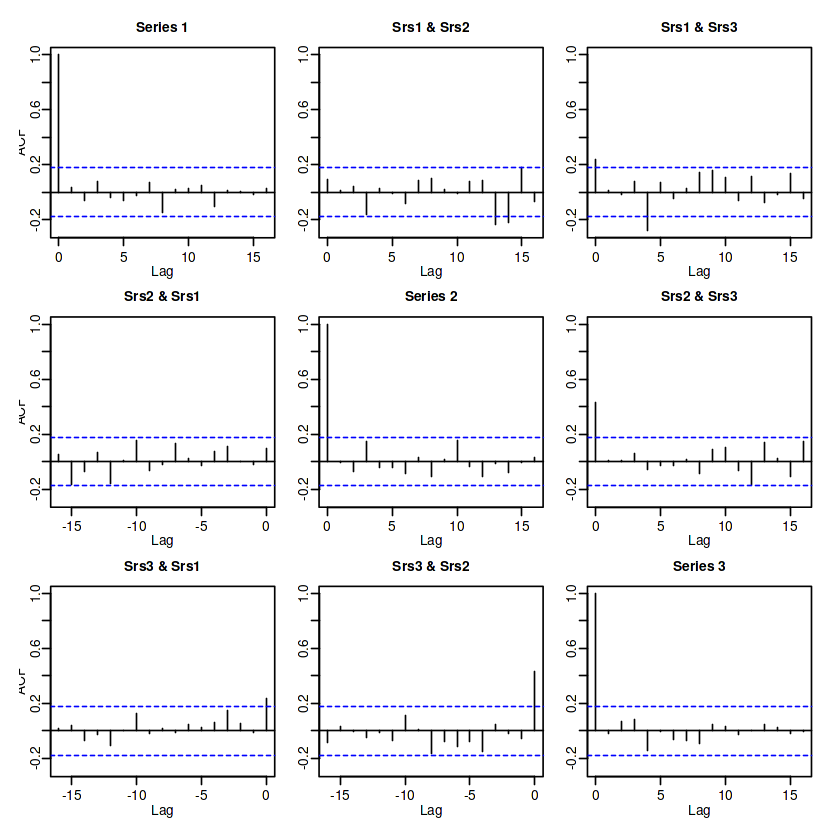

In [66]:
#Podemos igualmente visualizar los rezagos de los residuales, en búsuqueda de rezagos no capturados por el modelo.
acf(resi) 

Podemos observar que existen p valores bajos de residuales y rezagos en los modelos que violan la significancia. Con ello, podemos optar por elegir un modelo más complejo o también, elegir primeramente si mediante el refinamiento del mismo, el modelo mejora. Esto, ya que recordemos que existían rezagos no significativos en el modelo.

<a id="11"></a> <br>
## C. Simplificación modelo
Procedemos con la simplificación del modelo, indicando el modelo del cual partimos y un punto de corte que corresponde estándar. 

In [67]:
# Aplicamos para la simplificación, la función refVAR().
m2=refVAR(m1,thres = 1.96)

Constant term: 
Estimates:  0.001628247 0 0.002827525 
Std.Error:  0.0006814101 0 0.0007972864 
AR coefficient matrix 
AR( 1 )-matrix 
      [,1]  [,2]  [,3]
[1,] 0.467 0.207 0.000
[2,] 0.334 0.270 0.496
[3,] 0.468 0.225 0.232
standard error 
       [,1]   [,2]   [,3]
[1,] 0.0790 0.0686 0.0000
[2,] 0.0921 0.0875 0.0913
[3,] 0.1027 0.0963 0.1023
AR( 2 )-matrix 
       [,1] [,2] [,3]
[1,]  0.000    0    0
[2,] -0.197    0    0
[3,] -0.301    0    0
standard error 
       [,1] [,2] [,3]
[1,] 0.0000    0    0
[2,] 0.0921    0    0
[3,] 0.1008    0    0
  
Residuals cov-mtx: 
             [,1]         [,2]         [,3]
[1,] 2.900367e-05 1.803456e-06 7.055856e-06
[2,] 1.803456e-06 3.080250e-05 1.459834e-05
[3,] 7.055856e-06 1.459834e-05 3.626878e-05
  
det(SSE) =  2.494104e-14 
AIC =  -31.16226 
BIC =  -30.936 
HQ  =  -31.07034 


##### 


Como podemos observar, ahora contamos con 10 + 2 grados de libertad (10 parámetros regresivos y 2 ordenadas significativas). Procedemos con la revisión de residuales.

<a id="12"></a> <br>
## D. Revisión del modelo

Ljung-Box Statistics:  
         m       Q(m)     df    p-value
 [1,]   1.00      1.78   -3.00     1.00
 [2,]   2.00     12.41    6.00     1.00
 [3,]   3.00     22.60   15.00     0.09
 [4,]   4.00     37.71   24.00     0.04
 [5,]   5.00     41.65   33.00     0.14
 [6,]   6.00     44.95   42.00     0.35
 [7,]   7.00     51.50   51.00     0.45
 [8,]   8.00     64.87   60.00     0.31
 [9,]   9.00     72.50   69.00     0.36
[10,]  10.00     81.58   78.00     0.37
[11,]  11.00     86.12   87.00     0.51
[12,]  12.00     98.08   96.00     0.42
[13,]  13.00    112.31  105.00     0.30
[14,]  14.00    121.89  114.00     0.29
[15,]  15.00    134.58  123.00     0.22
[16,]  16.00    139.16  132.00     0.32
[17,]  17.00    145.85  141.00     0.37
[18,]  18.00    152.56  150.00     0.43
[19,]  19.00    165.91  159.00     0.34
[20,]  20.00    175.22  168.00     0.34
[21,]  21.00    180.56  177.00     0.41
[22,]  22.00    187.40  186.00     0.46
[23,]  23.00    193.78  195.00     0.51
[24,]  24.00    

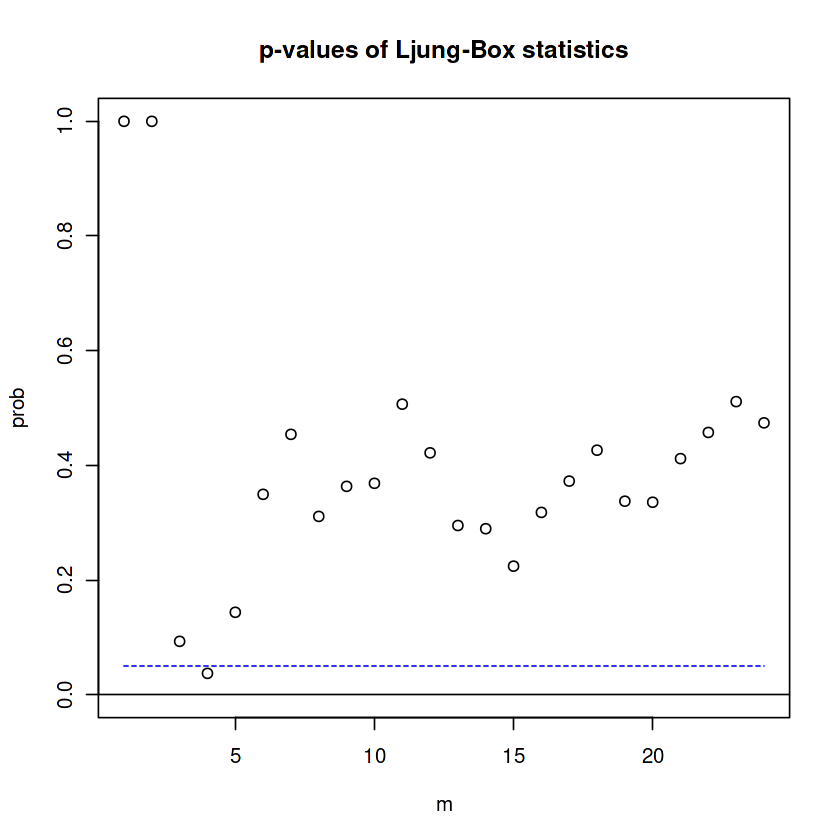

In [68]:
# Separamos nuevamente los residuales del modelo refinado y aplicamos función de revisión mediante función mq()
resi2=m2$residuals
mq(resi2, adj=12)

Podemos ver que el modelo mejoró, pero posiblemente una nueva iteración para una nueva mejora sería ajsutarlo a VAR(4). Esto, ya que es en el rezago de 4 cuando el p-valor cae en la prueba de LJung Box, lo que indicaría una dependencia.

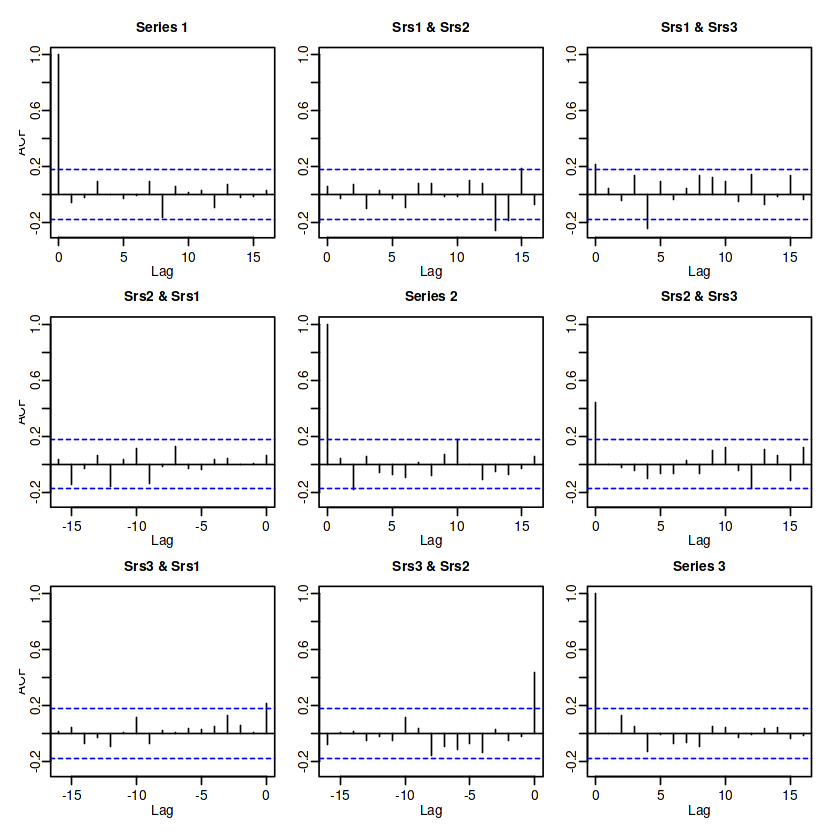

In [25]:
#Podemos visualizar nuevamente los residuales, donde vemos nuevamente la mejoría respecto al modelo completo.
acf(resi2)

In [69]:
# Aplicamos la función de diagnóstico al modelo terminal, esto, para permitir observar si existe una dependencia inmediata en las series.
MTSdiag(m2, adj=12) #Recordar que el modelo se reduce a 12 parámetros.

[1] "Covariance matrix:"
         uk       ca       us
uk 2.92e-05 1.82e-06 7.11e-06
ca 1.82e-06 3.08e-05 1.47e-05
us 7.11e-06 1.47e-05 3.66e-05
CCM at lag:  0 
       [,1]   [,2]  [,3]
[1,] 1.0000 0.0605 0.218
[2,] 0.0605 1.0000 0.438
[3,] 0.2175 0.4382 1.000
Simplified matrix: 
CCM at lag:  1 
. . . 
. . . 
. . . 
CCM at lag:  2 
. . . 
. . . 
. . . 
CCM at lag:  3 
. . . 
. . . 
. . . 
CCM at lag:  4 
. . - 
. . . 
. . . 
CCM at lag:  5 
. . . 
. . . 
. . . 
CCM at lag:  6 
. . . 
. . . 
. . . 
CCM at lag:  7 
. . . 
. . . 
. . . 
CCM at lag:  8 
. . . 
. . . 
. . . 
CCM at lag:  9 
. . . 
. . . 
. . . 
CCM at lag:  10 
. . . 
. . . 
. . . 
CCM at lag:  11 
. . . 
. . . 
. . . 
CCM at lag:  12 
. . . 
. . . 
. . . 
CCM at lag:  13 
. - . 
. . . 
. . . 
CCM at lag:  14 
. - . 
. . . 
. . . 
CCM at lag:  15 
. + . 
. . . 
. . . 
CCM at lag:  16 
. . . 
. . . 
. . . 
CCM at lag:  17 
. . . 
. . . 
. . . 
CCM at lag:  18 
. . . 
. . . 
. . . 
CCM at lag:  19 
. . . 
. . + 
. . . 
CCM at

Podemos observar que no existen correlaciones instantáneas entre las series. Esto, ya que los p-valores de la matriz de CCM lag 0, son mayores a la significancia del 5%. Si lo  evaluamos la significancia al 10%, únicamnete habría una correlación instantánea ente UK y Canadá.

<a id="13"></a> <br>
## 6. Análisis Impulso - Respuesta
Analicemos ahora las funciones de impulso respuesta.

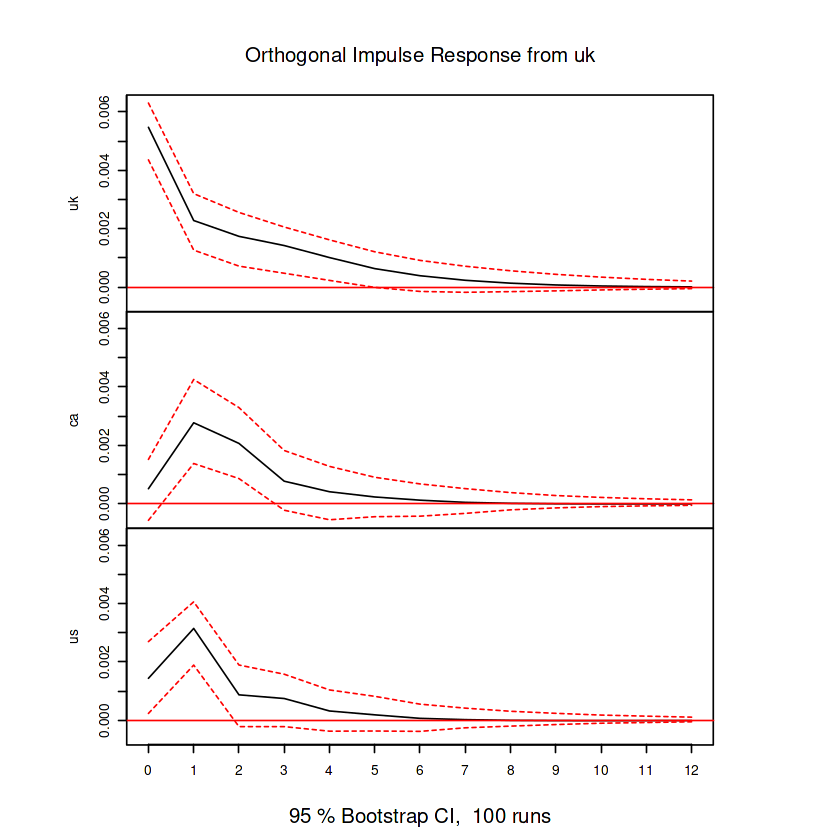

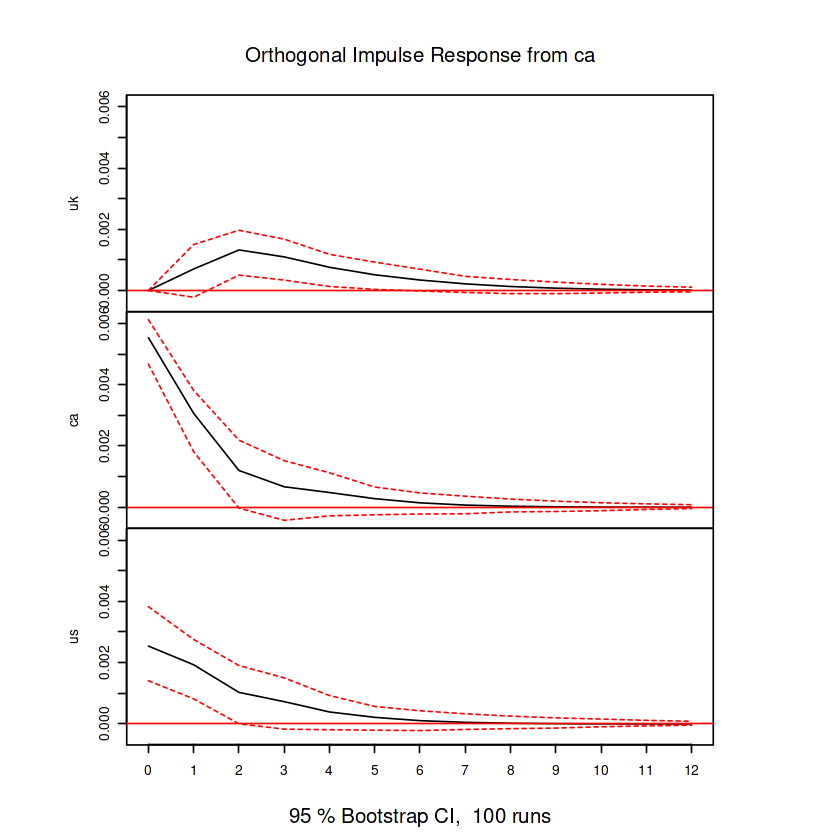

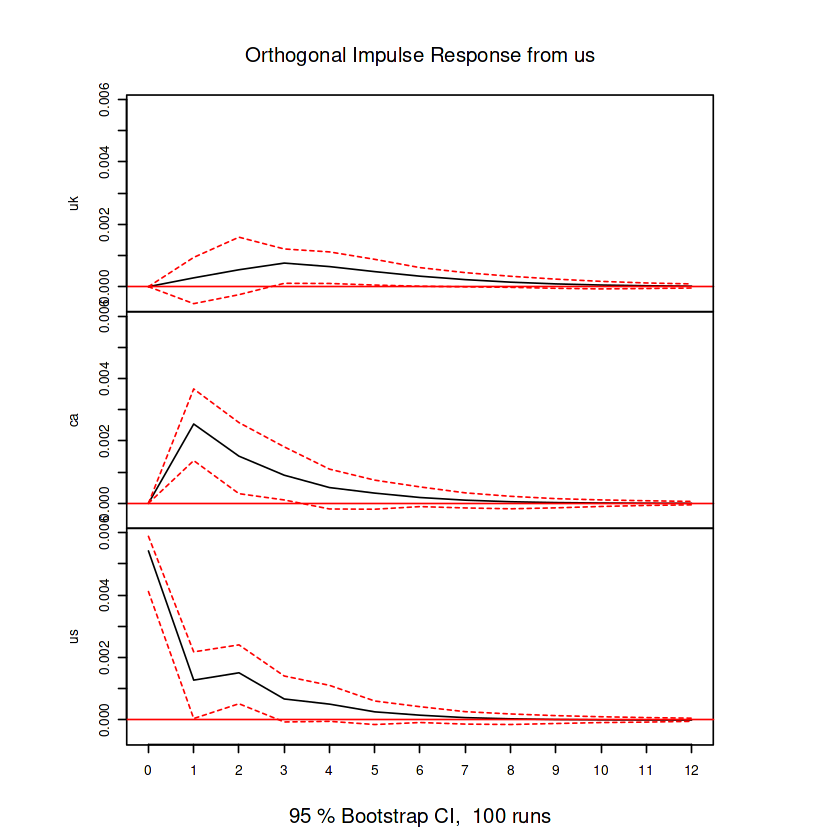

In [71]:
# La función de impulso respuesta se lleva a cabo mediante la librería de vars. La función es la irf(). Apliquemos la función al primer modelo.
m1irf = irf(m0, n.ahead = 12, boot = TRUE)
plot(m1irf) 

Como se puede observar, existe un efecto retardado en el crecimiento del PIB de UK si existiera un cambio de una unidad en la tasa de crecimiento en USA. Este efecto se debe a que, el cambio en una unidad de la tasa PIB de USA en un tiempo t, afecta el de Canadá en el t+1, el cual afecta también el de UK en t+2. Sigamos con la predicción del modelo.

<a id="15"></a> <br>
### 7. Predicción

In [88]:
#Apliquemos la predicción al segundo modelo. Esto, ya que la función VARpredict pertenece a la librería de MTS.
#Igualmente, podemos observar que se generan los resultados de pronóstico de cada una de las series y las ecuaciones de estimación de las series.
predm2=VARpred(m2, 6)  #Podemos generar un pronóstico a 6 trimestres adelante.
var_est3 <- VAR(y=z, lag.max = 2)
summary(var_est3)

orig  125 
Forecasts at origin:  125 
            uk        ca       us
 [1,] 0.002123 0.0009258 0.002668
 [2,] 0.002812 0.0019635 0.004158
 [3,] 0.003348 0.0031165 0.004911
 [4,] 0.003837 0.0038453 0.005388
 [5,] 0.004216 0.0043371 0.005730
 [6,] 0.004495 0.0046702 0.005950
 [7,] 0.004695 0.0048881 0.006092
 [8,] 0.004833 0.0050293 0.006184
 [9,] 0.004926 0.0051197 0.006241
[10,] 0.004989 0.0051768 0.006277
[11,] 0.005030 0.0052125 0.006299
[12,] 0.005057 0.0052346 0.006313
Standard Errors of predictions:  
          [,1]     [,2]     [,3]
 [1,] 0.005386 0.005550 0.006022
 [2,] 0.006083 0.007198 0.007041
 [3,] 0.006444 0.007839 0.007317
 [4,] 0.006645 0.008100 0.007453
 [5,] 0.006746 0.008218 0.007510
 [6,] 0.006796 0.008269 0.007534
 [7,] 0.006820 0.008290 0.007544
 [8,] 0.006831 0.008299 0.007548
 [9,] 0.006836 0.008303 0.007550
[10,] 0.006838 0.008304 0.007550
[11,] 0.006839 0.008304 0.007551
[12,] 0.006840 0.008305 0.007551
Root mean square errors of predictions:  
          [,1] 


VAR Estimation Results:
Endogenous variables: uk, ca, us 
Deterministic variables: const 
Sample size: 123 
Log Likelihood: 1408.82 
Roots of the characteristic polynomial:
0.6136 0.6136 0.356 0.3321 0.3321 0.03676
Call:
VAR(y = z, lag.max = 2)


Estimation results for equation uk: 
uk = uk.l1 + ca.l1 + us.l1 + uk.l2 + ca.l2 + us.l2 + const 

       Estimate Std. Error t value Pr(>|t|)    
uk.l1 0.3930669  0.0934184   4.208 5.11e-05 ***
ca.l1 0.1031057  0.0983843   1.048    0.297    
us.l1 0.0521366  0.0911264   0.572    0.568    
uk.l2 0.0566012  0.0923736   0.613    0.541    
ca.l2 0.1055224  0.0875590   1.205    0.231    
us.l2 0.0188946  0.0938209   0.201    0.841    
const 0.0012582  0.0007266   1.731    0.086 .  
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


Residual standard error: 0.005473 on 116 degrees of freedom
Multiple R-Squared: 0.3829,	Adjusted R-squared: 0.3509 
F-statistic: 11.99 on 6 and 116 DF,  p-value: 1.907e-10 


Estimation results for equ

<a id="16"></a> <br>
### 8. Recuperación del nivel en el pronóstico

Ya que los resultados de pronóstico están en unidades diferenciadas de las series, un paso ideal es la aplicación de una función que permita la recuperación del nivel. A continuación, una propuesta para tal recuperación.

In [109]:
#Especificamos el horizonte de pronóstico.
nhor=6 #pasos en el pronóstico.
nr_lev <- nrow(da)
mr_lev= as.matrix(da)
tail(mr_lev)
str(mr_lev)

,year,mon,uk,ca,us
"[121,]",2010,1,325360,1312845,12937700
"[122,]",2010,4,328836,1320294,13058500
"[123,]",2010,7,330860,1328350,13139600
"[124,]",2010,10,329189,1338481,13216100
"[125,]",2011,1,330724,1350078,13227900
"[126,]",2011,4,331263,1348342,13271800


 int [1:126, 1:5] 1980 1980 1980 1980 1981 1981 1981 1981 1982 1982 ...
 - attr(*, "dimnames")=List of 2
  ..$ : NULL
  ..$ : chr [1:5] "year" "mon" "uk" "ca" ...


In [110]:
# Generamos primeramente una estructura de datos con NAs que se poblarán con los valores de pronóstico, que se irán sumando acumuladamente.
m.varf_lev_ft <- rbind(mr_lev[,3:5], matrix(NA, nhor,3 ))
head(m.varf_lev_ft)
tail(m.varf_lev_ft)

uk,ca,us
172436,624794,5908500
169359,623433,5787400
169038,623215,5776600
167180,630215,5883500
166052,645957,6005700
166393,651954,5957800


,uk,ca,us
"[127,]",NA,NA,NA
"[128,]",NA,NA,NA
"[129,]",NA,NA,NA
"[130,]",NA,NA,NA
"[131,]",NA,NA,NA
"[132,]",NA,NA,NA


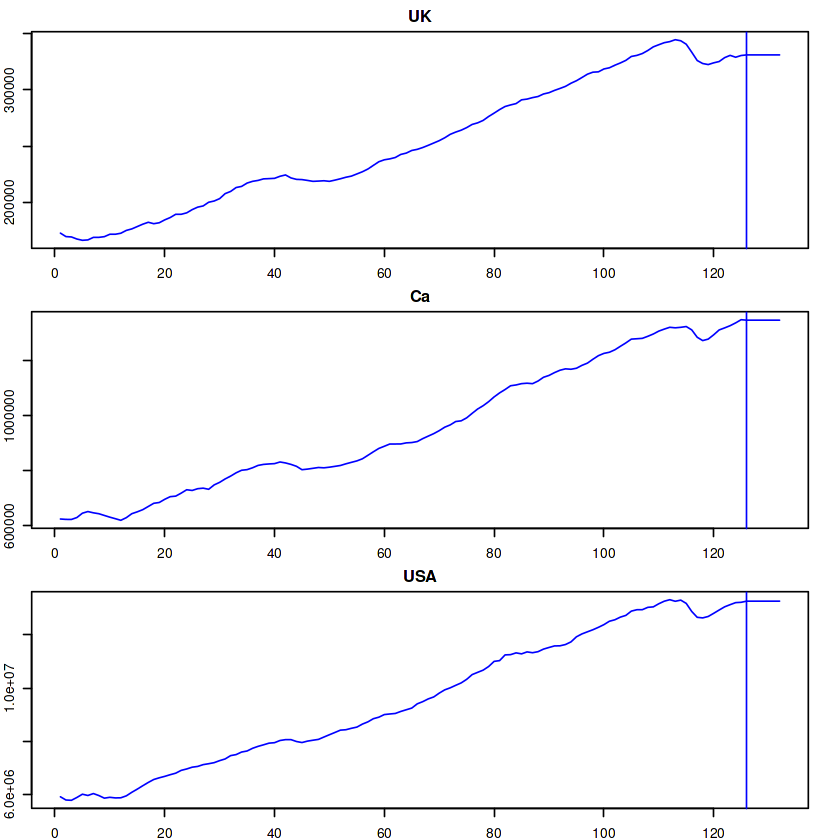

In [114]:
#En la función de recuperación, especificamos los valores que se consideran del modelo seleccionado. Generamos igualmente una visualización del resultado.
m.ft_df <- predm2$pred
for(h in (nr_lev+1):(nr_lev+nhor)) {
  hf <- h - nr_lev
  m.varf_lev_ft[h,] <- m.varf_lev_ft[h-1,] + m.ft_df[hf,]
}
str.main=c("UK", "Ca", "USA")
par(mfrow=c(3,1), mar=c(2,2,2,2))
for(i in 1:3) {
  df <- m.varf_lev_ft[,i]
  matplot(df, type=c("l"), col = c("blue"), 
          main = str.main[i]) 
  abline(v=nr_lev, col="blue")
}

En este tutorial, aprendimos a aplicar los conceptos del modelo VAR, donde inicialmente debemos identificar si los datos son candidatos a ser modelados mediante este enfoque. Ya que la serie era no cointegrada y no eran series estacionarias, procedimos a diferenciarlas para aplicar el modelo VAR. Proseguimos con la identificación del orden regresivo y armado del modelo de regresión. Esto, particularmente mediante dos librerías de uso común. Posteriormente, aplicamos las funciones de impulso respuesta que nos llevan a comprender mejor qué pasaría ante diferentes choques o situaciones de estrés en los valores de las series, mediante una alteración de sus valores, vimos sus comportamientos esperados. Finalmente, aplicamos la función de pronóstico al modelo vectorial seleccionado, para posteriormente recuperar el nivel y con ello, obtener las unidades originales de las series.